# Analyze problem statement to identify approach to fulfill goals

Company faces significant challenges in optimizing crop yields and resource management <br>
Need to prioritize focus on these 2 objectives

1. Predict temperature conditions within farm's closed environment, ensuring optimal plant growth
  - Regression modelling task
  - Need to identify relevant/related features within provided database
<br><br>
2. Categorize combined "Plant Type-Stage" based on sensor data, aiding in strategic planning and resource allocation
  - Classification modelling task
  - Need to identify relevant/related features within provided database

# Setup environment, SQL connection and analyze SQL database

Necessary libraries will be imported when needed

Establish connection SQL database (agri.db) using relative path 'data/agri.db'

In [1]:
# Import libraries as needed
import sqlite3

# Set path to SQL database
db_path = "data/agri.db"

# Create connection to SQL database
conn = sqlite3.connect(db_path)

Set pandas options for better readability

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None) # Display all columns in DataFrame
pd.set_option('display.max_rows', 100)     # Limit number of rows displayed to 100

Explore database structure by listing all tables to identify available tables for extraction

In [3]:
import pandas as pd

# Query to list all tables in database
query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

# Display list of tables
tables

,name
0,farm_data


Since there is only 'farm_data' table in the database, the first few rows can be previewed to understand the column structure <br>
This can be cross-checked with the provided list of attributes in the PDF

In [4]:
# Preview first few rows of 'farm_data' table
farm_data_10_query = "SELECT * FROM farm_data LIMIT 10;"
farm_data_10_df = pd.read_sql(farm_data_10_query, conn)

# Display first few rows of table
farm_data_10_df.head(10)

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,Vine Crops,Maturity,23.34,NaN,454.0,937,1.82,4,161,64,201,6.1,28.150346
1,Zone_G,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161,53,None,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.84,NaN,562.0,1246,1.21,8,228,79,292,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,Vegetative,22.61,NaN,651.0,1346,1.96,6,None,53 ppm,289,6.6,NaN
4,Zone_B,Vine Crops,LEAFY GREENS,seedling,22.88,NaN,144.0,812,2.76,5,61,19,168,5.5,28.000000
5,Zone_C,Vine Crops,FRUITING VEGETABLES,MATURITY,25.96,NaN,675.0,1338,1.75,8,227,53,258,6.2,23.092135
6,Zone_A,Leafy Greens,Vine Crops,Maturity,NaN,NaN,514.0,1103,1.14,8,174,62,217,5.5,35.000000
7,Zone_G,Herbs,Leafy Greens,Maturity,20.16,NaN,317.0,1133,1.52,10,None,None,277,5.8,39.611156
8,Zone_G,Herbs,Leafy Greens,Maturity,20.16,NaN,317.0,1133,1.52,10,None,None,277,5.8,39.611156
9,Zone_B,Vine Crops,Vine Crops,MATURITY,25.59,NaN,435.0,845,2.07,8,150,70,210,5.3,27.835062


There are a few issues in the current database that will have to be sorted out before the data can be used for feature engineering or used in machine learning modelling <br>
<br>
Currently identified issues:
| Column Name | Issue |
| :---------: | :---: |
| Plant Type  | Non-standardized naming format |
| Plant Stage | Non-standardized naming format |
| Temperature Sensor | Missing values (NaN) |
|                    | Negative value |
| Humidity Sensor | Missing values (NaN) |
| Nutrient * Sensor | Missing value (None) |
|                   | Values with units |
| Water Level Sensor | Missing value (NaN) |

The schema of 'farm_data' table can be retrieved to understand the columns' data type <br>
However, this might not be fully accurate prior to data clean-up due to missing or incorrectly labelled values

In [5]:
# Get schema of 'farm_data' table
schema_query = "PRAGMA table_info(farm_data);"
schema_df = pd.read_sql(schema_query, conn)

# Display schema information
schema_df

,cid,name,type,notnull,dflt_value,pk
0,0,System Location Code,TEXT,0,None,0
1,1,Previous Cycle Plant Type,TEXT,0,None,0
2,2,Plant Type,TEXT,0,None,0
3,3,Plant Stage,TEXT,0,None,0
4,4,Temperature Sensor (°C),REAL,0,None,0
5,5,Humidity Sensor (%),REAL,0,None,0
6,6,Light Intensity Sensor (lux),REAL,0,None,0
7,7,CO2 Sensor (ppm),INTEGER,0,None,0
8,8,EC Sensor (dS/m),REAL,0,None,0
9,9,O2 Sensor (ppm),INTEGER,0,None,0


Most of the columns' data type match expectations, except for Nutrient Sensors <br>
These columns should have REAL/INTEGER type but are currently of TEXT type <br> <br>
To handle this, the missing values will have to resolved and the values with units need to be processed <br>
After both steps are done, the columns' data can be converted to REAL/INTEGER type

# Perform Exploratory Data Analysis (EDA) on SQL table data

Load all data from 'farm_data' table into a DataFrame to start data analysis

In [6]:
# Get all data from 'farm_data' table
farm_data_query = "SELECT * FROM farm_data;"
farm_data_df = pd.read_sql_query(farm_data_query, conn)

Start with data preprocessing to clean-up missing values, non-standardized naming format and extra info in values

The data in columns (Plant Type, Plant Stage) will all be changed to lowercase characters to standardize the data

In [7]:
non_standard_name_list = ["Plant Type", "Plant Stage"]

for col_name in non_standard_name_list:
    farm_data_df[col_name] = farm_data_df[col_name].str.lower()


Remove 'ppm' from Nutrient * Sensor column data and convert the data into numeric type

In [8]:
ppm_drop_list = ["Nutrient N Sensor (ppm)", "Nutrient P Sensor (ppm)", "Nutrient K Sensor (ppm)"]

for col_name in ppm_drop_list:
    farm_data_df[col_name] = farm_data_df[col_name].str.replace("ppm", "", regex=False)
    farm_data_df[col_name] = pd.to_numeric(farm_data_df[col_name], errors="coerce")

Remove negative sign in Temperature Sensor column data

In [9]:
# Get Temperature Sensor column name
farm_data_df_col_list = farm_data_df.columns

for col_name in farm_data_df_col_list:
    if "Temperature Sensor" in col_name:
        temp_sensor_col_name = col_name

farm_data_df[temp_sensor_col_name] = farm_data_df[temp_sensor_col_name].abs()

After checking the current DataFrame, it seems that Light Intensity Sensor column also has missing values <br>
So that will be handled together with the other affected columns

For the remaining columns with missing values, they will be filled with either mean or median values of their zone <br>
The existing data of each column will be grouped into their System Location Code to obtain the mean and median values

Here is the breakdown of each column:
| Column Name | Mean/Median | Reason |
| :---------: | :---------: | :----: |
| Temperature Sensor | Mean | Data is relatively stable and has normal distribution |
| Humidity Sensor | Median  | Data is not normally distributed, no clear pattern |
| Light Intensity Sensor | Median | Data is skewed towards the upper half of the spectrum |
| Nutrient N Sensor | Median | Data has sudden dip and spike near right of spectrum |
| Nutrient P Sensor | Median | Data has sudden dip and spike near left of spectrum |
| Nutrient K Sensor | Median | Data has sudden dip and spike near right of spectrum |
| Water Level Sensor | Median | To avoid outliers at extreme ends of spectrum |

The mean and median of each column with missing value is still calculated and displayed

In [10]:
agg_list = ["mean", "median"]
no_nan_col_list = farm_data_df.columns[farm_data_df.isnull().sum() == 0].tolist()
# Don't drop 'System Location Code' column else there is no zone to groupby
no_nan_col_list = [col for col in no_nan_col_list if col != "System Location Code"]

nan_farm_data_df =  farm_data_df.drop(columns=no_nan_col_list)

nan_farm_data_grouped_df = nan_farm_data_df.groupby("System Location Code").agg(agg_list)

nan_farm_data_grouped_df

Temperature Sensor (°C)        Humidity Sensor (%)  \
                                        mean median                mean   
System Location Code                                                      
Zone_A                             23.369253  23.29           69.187693   
Zone_B                             23.353886  23.29           69.342692   
Zone_C                             23.312684  23.24           69.323220   
Zone_D                             23.312144  23.26           69.036619   
Zone_E                             23.328869  23.25           69.116904   
Zone_F                             23.349125  23.26           69.331217   
Zone_G                             23.329252  23.28           69.372539   

                             Light Intensity Sensor (lux)         \
                      median                         mean median   
System Location Code                                               
Zone_A                68.705                   399.275789  407.0   
Zone_B                68.850                   393.395599  400.0   
Zone_C                68.690                   398.449472  404.0   
Zone_D                68.285                   396.918868  400.0   
Zone_E                68.500                   394.645216  401.0   
Zone_F                69.020                   403.212830  410.0   
Zone_G                68.765                   399.016228  402.0   

                     Nutrient N Sensor (ppm)        Nutrient P Sensor (ppm)  \
                                        mean median                    mean   
System Location Code                                                          
Zone_A                            157.932325  158.0               50.078983   
Zone_B                            157.452402  158.0               49.773273   
Zone_C                            156.531433  156.0               49.871046   
Zone_D                            156.983491  158.0               49.497572   
Zone_E                            158.294048  158.0               49.817683   
Zone_F                            159.045950  159.0               49.928318   
Zone_G                            157.573304  159.0               50.037606   

                            Nutrient K Sensor (ppm)         \
                     median                    mean median   
System Location Code                                         
Zone_A                 50.0              218.071082  214.0   
Zone_B                 50.0              217.631057  214.0   
Zone_C                 50.0              217.574829  215.0   
Zone_D                 49.0              217.813904  215.0   
Zone_E                 50.0              217.959634  214.0   
Zone_F                 50.0              218.664829  214.5   
Zone_G                 50.0              218.222765  215.0   

                     Water Level Sensor (mm)             
                                        mean     median  
System Location Code                                     
Zone_A                             25.738490  26.000000  
Zone_B                             25.702412  25.403759  
Zone_C                             25.591987  25.040820  
Zone_D                             25.776124  26.000000  
Zone_E                             25.790265  26.000000  
Zone_F                             25.763893  26.000000  
Zone_G                             25.657235  26.000000

It can be seen that for each column, the mean and median values differ by some margin <br>
So choosing the appropriate one to replace missing value is important

The missing values of each column will be replaced as showed in the above table

In [11]:
# Create new DataFrame for data after removing missing values
clean_farm_data_df = farm_data_df

# Replace 'Temperature Sensor' column missing value with mean
clean_farm_data_df[temp_sensor_col_name] = clean_farm_data_df[temp_sensor_col_name].fillna(clean_farm_data_df[temp_sensor_col_name].mean())

nan_col_list = clean_farm_data_df.columns[clean_farm_data_df.isnull().any()].tolist()
# Remove 'Temperature Sensor' column name from list as it uses mean instead of median
nan_col_list = [col for col in nan_col_list if col != temp_sensor_col_name]

# Replace remaining affected column missing value with median
for col_name in nan_col_list:
    clean_farm_data_df[col_name] = clean_farm_data_df[col_name].fillna(clean_farm_data_df[col_name].median())

clean_farm_data_df

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,vine crops,maturity,23.340000,68.70,454.0,937,1.82,4,161.0,64.0,201.0,6.1,28.150346
1,Zone_G,Herbs,vine crops,vegetative,24.160000,63.14,441.0,938,2.13,6,161.0,53.0,215.0,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.840000,68.70,562.0,1246,1.21,8,228.0,79.0,292.0,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,vegetative,22.610000,68.70,651.0,1346,1.96,6,158.0,53.0,289.0,6.6,26.000000
4,Zone_B,Vine Crops,leafy greens,seedling,22.880000,68.70,144.0,812,2.76,5,61.0,19.0,168.0,5.5,28.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57484,Zone_C,Vine Crops,fruiting vegetables,maturity,23.336438,68.70,619.0,1074,1.95,6,150.0,61.0,210.0,6.4,26.000000
57485,Zone_C,Vine Crops,fruiting vegetables,maturity,23.336438,68.70,619.0,1074,1.95,6,150.0,61.0,210.0,6.4,26.000000
57486,Zone_E,Herbs,vine crops,seedling,24.850000,68.70,203.0,816,0.98,7,121.0,41.0,114.0,4.9,21.000000
57487,Zone_G,Fruiting Vegetables,vine crops,vegetative,23.450000,64.89,502.0,911,2.27,5,190.0,57.0,196.0,5.9,35.000000


Based on the current data and data types, each column can be categorized as categorical or numerical types <br>
Categorical represents categories or labels, so usually the data are of string or object data type <br>
Numerical represents quantiative data, which can be either continuous or discrete

Here is the breakdown:
| Column Name | Type |
| :---------: | :--: |
| System Location Code | Categorical |
| Previous Cycle Plant Type | Categorical |
| Plant Type | Categorical |
| Plant Stage | Categorical |
| Temperature Sensor | Numerical |
| Humidity Sensor | Numerical |
| Light Intensity Sensor | Numerical |
| CO2 Sensor | Numerical |
| EC Sensor | Numerical |
| O2 Sensor | Numerical |
| Nutrient * Sensor | Numerical |
| pH Level | Numerical |
| Water Level Sensor | Numerical |

The distribution of the categorical variables are plotted for visualization <br>
It is to get a sense of how the data is categorized and the evenness of the distribution

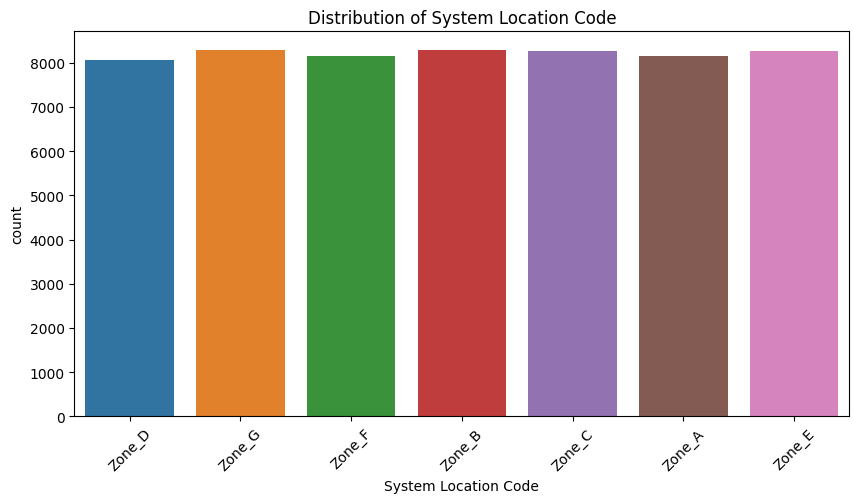

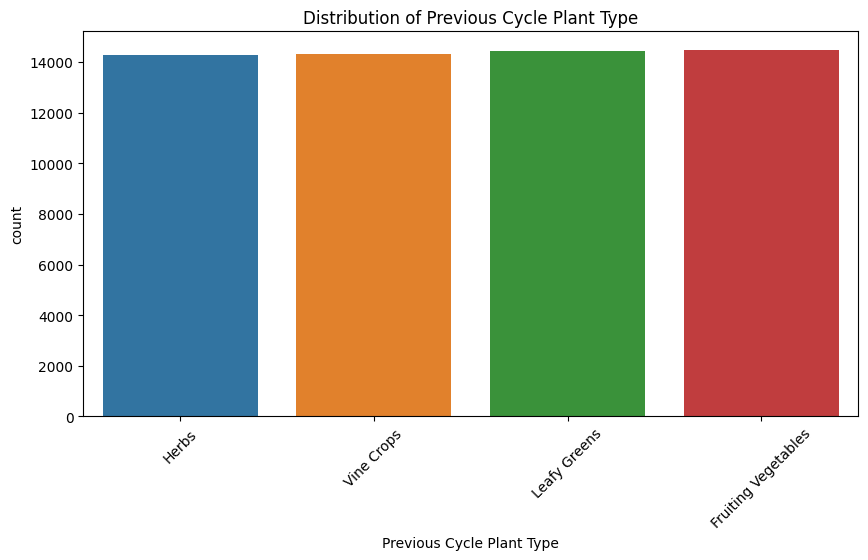

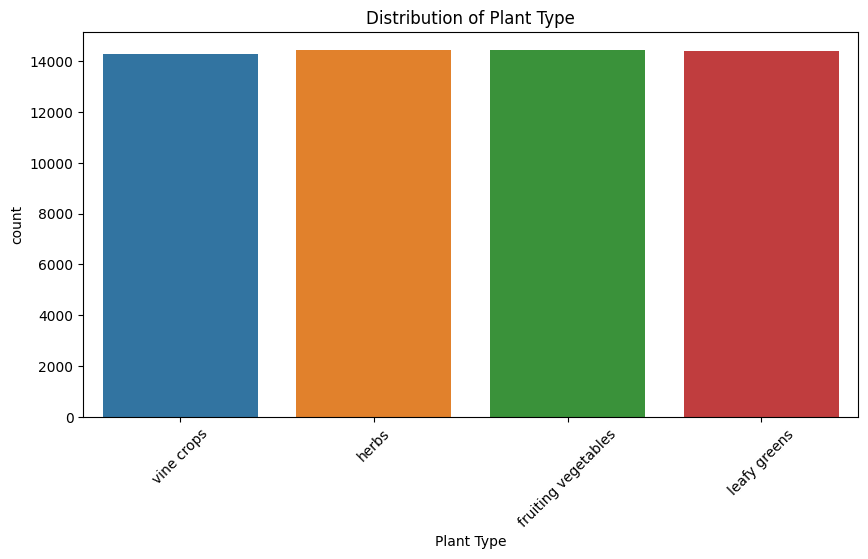

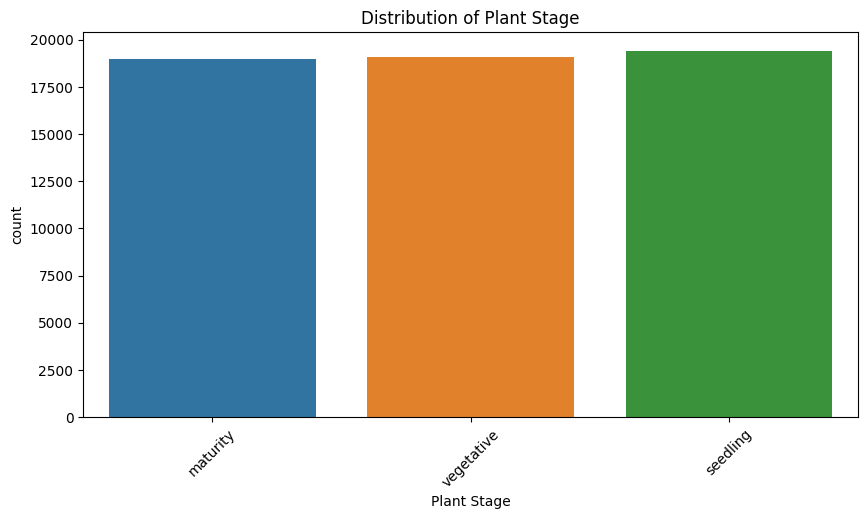

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

cat_col_list = ["System Location Code", "Previous Cycle Plant Type", "Plant Type", "Plant Stage"]

for col_name in cat_col_list:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col_name, data=clean_farm_data_df)
    plt.title(f"Distribution of {col_name}")
    plt.xticks(rotation=45)
    plt.show()

It can be seen that the data distribution of all 4 columns are rather even across all the distinct values <br>
It means that there is no need to do any further data processing to balance out skewed data

The distribution and relationship of numerical variables are plotted for visualization

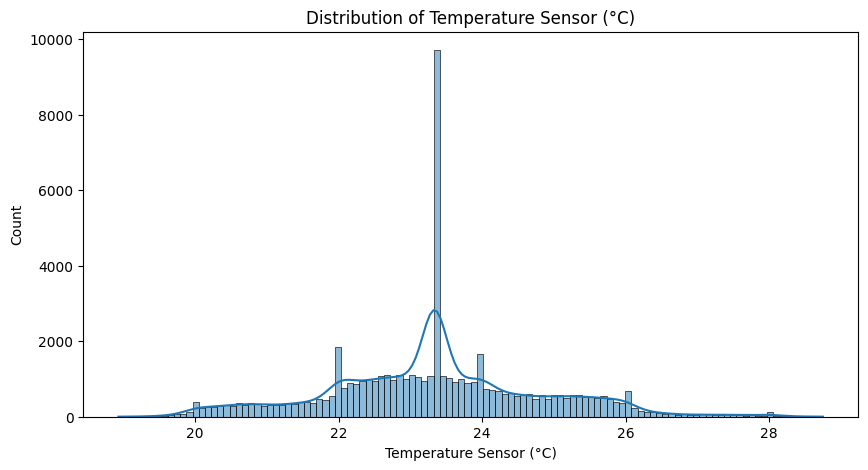

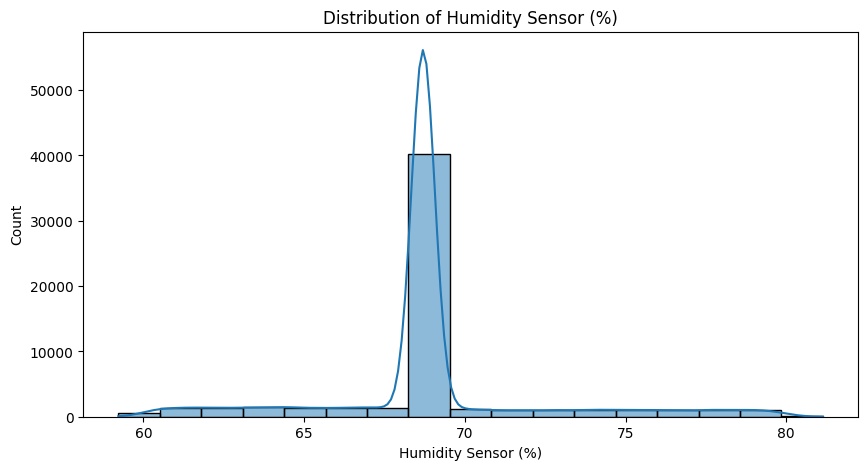

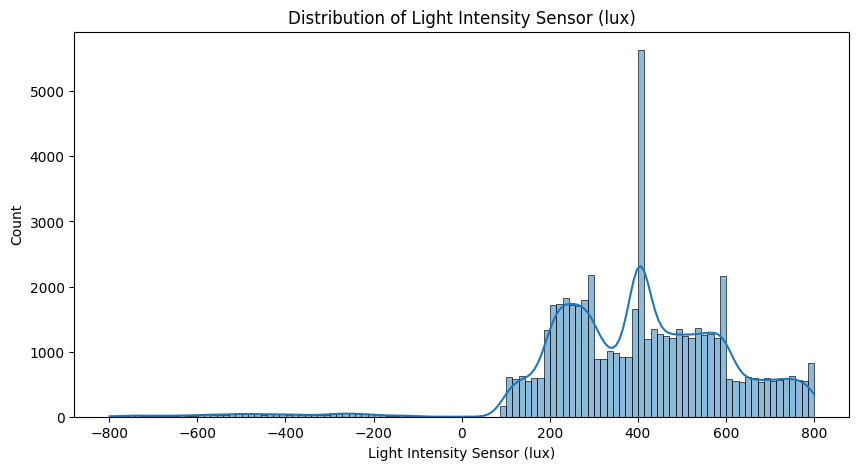

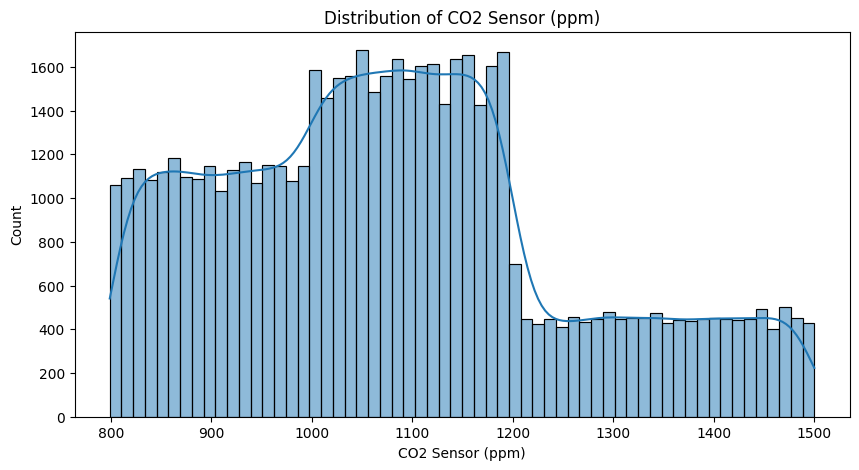

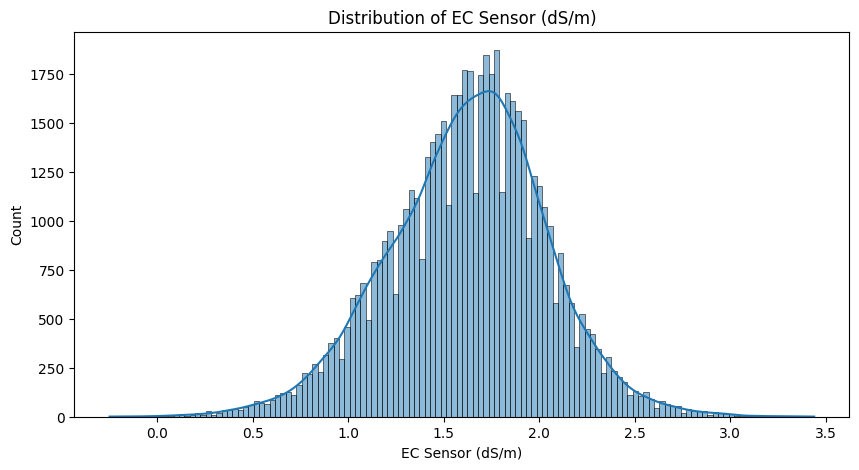

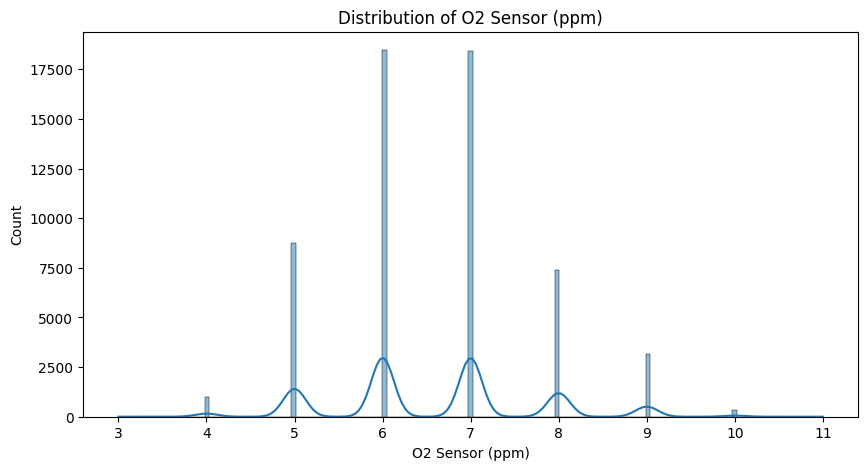

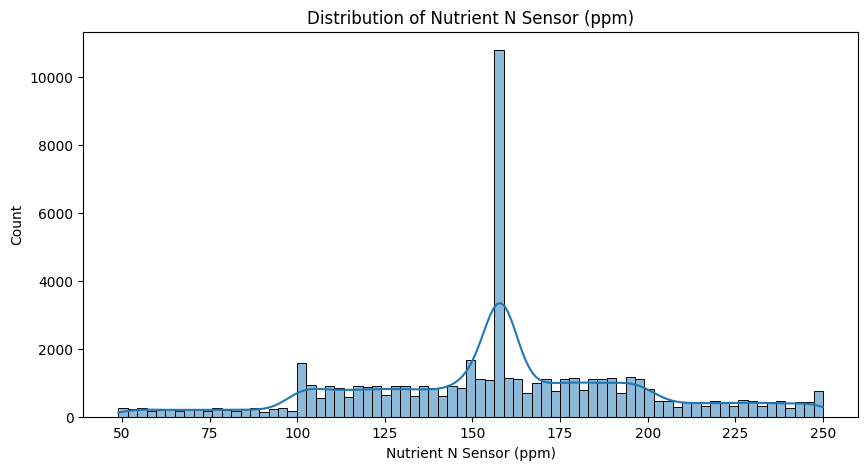

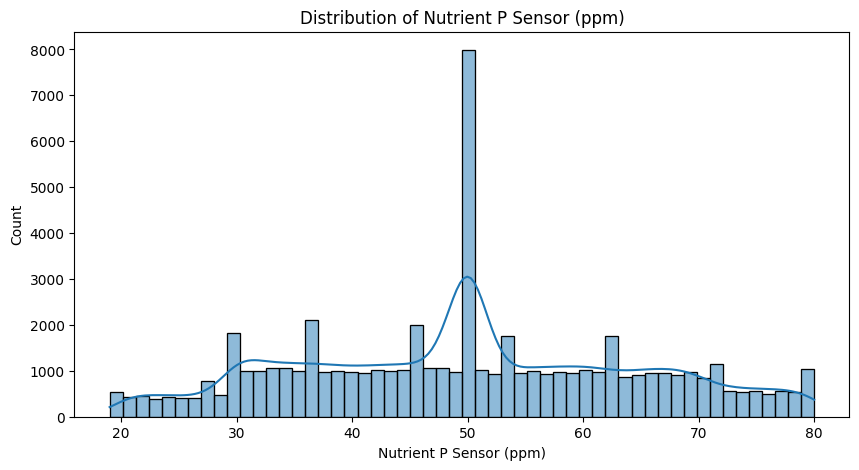

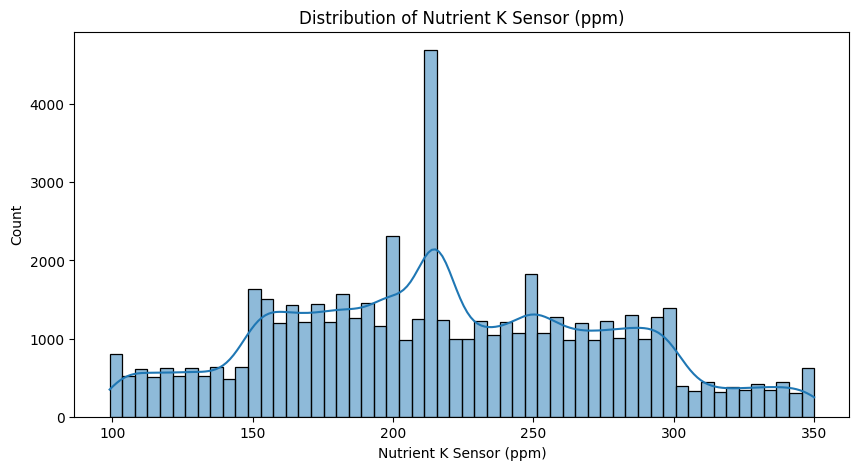

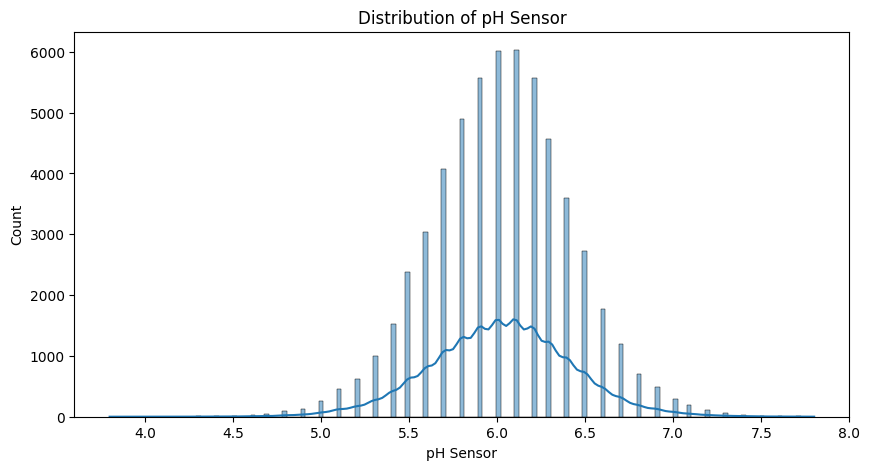

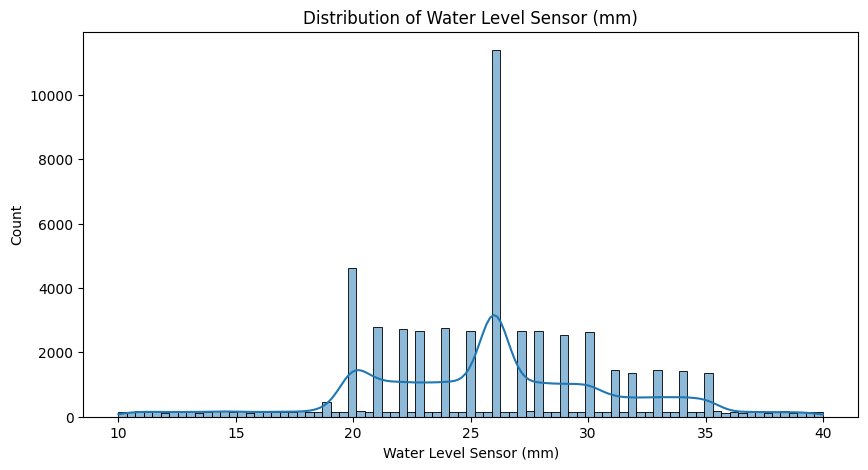

In [13]:
num_col_list = [item for item in farm_data_df_col_list if item not in cat_col_list]

for col_name in num_col_list:
    plt.figure(figsize=(10,5))
    sns.histplot(clean_farm_data_df[col_name], kde=True)
    plt.title(f"Distribution of {col_name}")
    plt.show()

After replacing the missing values, there is a sharp sudden spike in the median region for the affected features <br>
This helps to create a normal distribution in the features but due to the number of missing values replaced creating a sharp spike, the impact will have to be assessed in the later stage